# Emotion Classification (6-Class)

## Overview

This notebook implements a **6-class emotion classifier** using semantic embeddings from an emotion-tuned RoBERTa model. The pipeline consists of:

| Step | Task | Description |
|------|------|-------------|
| 0 | Setup | Environment configuration and reproducibility |
| 1 | Data Ingestion | Load dair-ai/emotion dataset (train/validation/test) |
| 2 | Text Normalization | Lightweight preprocessing preserving emotional cues |
| 3 | Semantic Embeddings | Extract 768-dim vectors via RoBERTa-emotion |
| 4 | Feature Standardization | Scale embeddings for classifier input |
| 5 | Model Training | Multinomial logistic regression with evaluation |
| 6 | Export Artifacts | Save model, scaler, and config for inference |

---

## Dataset: dair-ai/emotion

The dataset contains English Twitter messages labeled with 6 basic emotions:

| Label | Emotion | Description |
|-------|---------|-------------|
| 0 | `sadness` | Feeling of sorrow or unhappiness |
| 1 | `joy` | Feeling of happiness or pleasure |
| 2 | `love` | Feeling of deep affection |
| 3 | `anger` | Feeling of strong displeasure |
| 4 | `fear` | Feeling of being afraid |
| 5 | `surprise` | Feeling of astonishment |

---

## Why This Approach?

Emotions in text are nuanced and context-dependent. We use **RoBERTa fine-tuned on emotion data** (`bhadresh-savani/roberta-base-emotion`) because:

- It's trained on the **same dair-ai/emotion dataset**, so embeddings encode emotion-specific patterns
- RoBERTa's robust pre-training captures subtle linguistic cues
- The 768-dimensional embeddings provide rich features for classification
- Combined with logistic regression, it offers interpretability and fast inference

<br>

---

## Task 00 — Environment Setup & Reproducibility

We establish a reproducible environment by:
1. **Fixing random seeds** across Python, NumPy, and PyTorch
2. **Importing all dependencies** upfront for clarity
3. **Defining utility functions** (logging, device selection)

### Dependencies
```
torch              # Neural network backend
transformers       # HuggingFace models (RoBERTa)
datasets           # HuggingFace data loading
scikit-learn       # Logistic regression, metrics, scaling
pandas, numpy      # Data manipulation
joblib             # Model serialization
```

In [2]:
# ============================================================================
# STEP 0 — ENVIRONMENT SETUP & REPRODUCIBILITY
# ============================================================================

# --- Standard Library ---
import os
import re
import random
import warnings
from typing import List

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Deep Learning ---
import torch
from transformers import AutoTokenizer, AutoModel

# --- Machine Learning ---
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# --- Data Loading ---
from datasets import load_dataset

# --- Model Persistence ---
import joblib

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress non-critical warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------
# Reproducibility Settings
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Device Configuration
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# Logging Utility
# -------------------------
def log(msg: str):
    """Simple logging function."""
    print(msg, flush=True)

# -------------------------
# Configuration Constants
# -------------------------
MODEL_NAME = "bhadresh-savani/roberta-base-emotion"  # Emotion-tuned RoBERTa
EMBEDDING_DIM = 768
MAX_SEQ_LENGTH = 128  # Tweets are short, 128 is sufficient
BATCH_SIZE = 32

# Emotion label mapping
EMOTION_LABELS = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

NUM_CLASSES = len(EMOTION_LABELS)

# Output paths for saved artifacts
OUTPUT_DIR = "./emotion_model_artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

log(f"[OK] Environment ready.")
log(f"     Device: {DEVICE}")
log(f"     Random seed: {SEED}")
log(f"     Embedding model: {MODEL_NAME}")
log(f"     Output directory: {OUTPUT_DIR}")

[OK] Environment ready.
     Device: cuda
     Random seed: 42
     Embedding model: bhadresh-savani/roberta-base-emotion
     Output directory: ./emotion_model_artifacts


<br>

---

## Task 01 — Data Ingestion

### Dataset: dair-ai/emotion

The dataset provides three splits:
- **Train**: 16,000 samples
- **Validation**: 2,000 samples  
- **Test**: 2,000 samples

Each sample contains:
- `text`: The tweet/message content
- `label`: Integer label (0-5) corresponding to emotion

### Label Distribution

The dataset has some class imbalance, with `joy` and `sadness` being more frequent than `surprise` and `love`.

In [3]:
# ============================================================================
# STEP 1 — DATA INGESTION
# ============================================================================
log("\n" + "="*70)
log("STEP 1 — DATA INGESTION")
log("="*70)

# ---------------------------------
# 1.1 Load Dataset from HuggingFace
# ---------------------------------
log("\n[1.1] Loading dair-ai/emotion dataset from HuggingFace...")

dataset = load_dataset("dair-ai/emotion")

# Convert to pandas DataFrames
df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()
df_test = dataset["test"].to_pandas()

log(f"     Train samples:      {len(df_train):,}")
log(f"     Validation samples: {len(df_val):,}")
log(f"     Test samples:       {len(df_test):,}")

# ---------------------------------
# 1.2 Add Emotion Names
# ---------------------------------
log("\n[1.2] Mapping labels to emotion names...")

df_train["emotion"] = df_train["label"].map(EMOTION_LABELS)
df_val["emotion"] = df_val["label"].map(EMOTION_LABELS)
df_test["emotion"] = df_test["label"].map(EMOTION_LABELS)

# ---------------------------------
# 1.3 Display Label Distribution
# ---------------------------------
log("\n[1.3] Label distribution (TRAIN):")
label_counts = df_train["emotion"].value_counts().sort_index()
for emotion, count in label_counts.items():
    pct = 100 * count / len(df_train)
    bar = "█" * int(pct / 2)
    log(f"     {emotion:>10}: {count:>5,} ({pct:>5.1f}%) {bar}")

log("\n[OK] Data ingestion complete.")


STEP 1 — DATA INGESTION

[1.1] Loading dair-ai/emotion dataset from HuggingFace...


README.md: 0.00B [00:00, ?B/s]

C:\Users\Pipoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pipoy\.cache\huggingface\hub\datasets--dair-ai--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

     Train samples:      16,000
     Validation samples: 2,000
     Test samples:       2,000

[1.2] Mapping labels to emotion names...

[1.3] Label distribution (TRAIN):
          anger: 2,159 ( 13.5%) ██████
           fear: 1,937 ( 12.1%) ██████
            joy: 5,362 ( 33.5%) ████████████████
           love: 1,304 (  8.2%) ████
        sadness: 4,666 ( 29.2%) ██████████████
       surprise:   572 (  3.6%) █

[OK] Data ingestion complete.


In [4]:
# ============================================================================
# PREVIEW: Sample Data
# ============================================================================

log("\n" + "-"*70)
log("SAMPLE DATA")
log("-"*70)

# Show examples from each emotion
for label_id, emotion in EMOTION_LABELS.items():
    sample = df_train[df_train["label"] == label_id].iloc[0]
    text = sample["text"][:80]
    log(f"\n[{emotion.upper():>10}] \"{text}...\"")


----------------------------------------------------------------------
SAMPLE DATA
----------------------------------------------------------------------

[   SADNESS] "i didnt feel humiliated..."

[       JOY] "i have been with petronas for years i feel that petronas has performed well and ..."

[      LOVE] "i am ever feeling nostalgic about the fireplace i will know that it is still on ..."

[     ANGER] "im grabbing a minute to post i feel greedy wrong..."

[      FEAR] "i feel as confused about life as a teenager or as jaded as a year old man..."

[  SURPRISE] "ive been taking or milligrams or times recommended amount and ive fallen asleep ..."


<br>

---

## Task 02 — Text Normalization

### Philosophy: Preserve Emotional Signals

For emotion detection, we apply **minimal normalization** to preserve:

| Feature | Example | Emotional Signal |
|---------|---------|------------------|
| Repeated punctuation | `"I'm so happy!!!"` | Intensity/excitement |
| ALL CAPS | `"I LOVE THIS"` | Strong emotion |
| Ellipsis | `"I feel so alone..."` | Sadness/hesitation |
| Emojis | `"😊"`, `"😢"` | Direct emotion indicators |

### Normalization Strategy

| Operation | Applied? | Reason |
|-----------|----------|--------|
| Lowercase | ✅ Yes | Reduces vocabulary sparsity |
| Whitespace normalization | ✅ Yes | Removes noise |
| Remove punctuation | ❌ No | Preserves emotional cues |
| Remove emojis | ❌ No | Preserves sentiment indicators |

In [5]:
# ============================================================================
# STEP 2 — TEXT NORMALIZATION
# ============================================================================
log("\n" + "="*70)
log("STEP 2 — TEXT NORMALIZATION")
log("="*70)

def normalize_text(text: str) -> str:
    """
    Apply minimal text normalization that preserves emotional signals.
    
    Operations:
        1. Convert to lowercase
        2. Collapse multiple whitespace to single space
        3. Strip leading/trailing whitespace
    
    Preserved:
        - Punctuation (!!!, ..., etc.)
        - Emojis and special characters
        - Numbers
    
    Args:
        text: Raw input string
    
    Returns:
        Normalized string
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()                        # Lowercase
    text = re.sub(r"\s+", " ", text).strip()   # Normalize whitespace
    
    return text

# Apply normalization to all datasets
log("\n[2.1] Normalizing TRAIN set...")
df_train["text_norm"] = df_train["text"].apply(normalize_text)

log("[2.2] Normalizing VALIDATION set...")
df_val["text_norm"] = df_val["text"].apply(normalize_text)

log("[2.3] Normalizing TEST set...")
df_test["text_norm"] = df_test["text"].apply(normalize_text)

# Display samples
log("\n[2.4] Sample normalized entries:")
log("-" * 50)
for idx in range(3):
    orig = df_train.iloc[idx]["text"][:60]
    norm = df_train.iloc[idx]["text_norm"][:60]
    emotion = df_train.iloc[idx]["emotion"]
    log(f"[{emotion}]")
    log(f"  Original:   {orig}...")
    log(f"  Normalized: {norm}...")
    log("")

log("[OK] Text normalization complete.")


STEP 2 — TEXT NORMALIZATION

[2.1] Normalizing TRAIN set...
[2.2] Normalizing VALIDATION set...
[2.3] Normalizing TEST set...

[2.4] Sample normalized entries:
--------------------------------------------------
[sadness]
  Original:   i didnt feel humiliated...
  Normalized: i didnt feel humiliated...

[sadness]
  Original:   i can go from feeling so hopeless to so damned hopeful just ...
  Normalized: i can go from feeling so hopeless to so damned hopeful just ...

[anger]
  Original:   im grabbing a minute to post i feel greedy wrong...
  Normalized: im grabbing a minute to post i feel greedy wrong...

[OK] Text normalization complete.


<br>

---

## Task 03 — Emotion-Aware Semantic Embeddings

### Model: RoBERTa-base (Emotion Fine-tuned)

We use `bhadresh-savani/roberta-base-emotion`, a RoBERTa model fine-tuned on the emotion classification task. This provides:

- **Emotion-specific representations**: Hidden states shaped by emotion classification objectives
- **768-dimensional embeddings**: Rich feature space for downstream classification
- **Domain alignment**: Trained on the same dataset we're using

### Embedding Extraction

Given input text $x$, the model produces contextualized token representations:

$$
H = \text{RoBERTa}(x) \in \mathbb{R}^{T \times 768}
$$

where $T$ is the sequence length. We apply **mean pooling** to obtain a fixed-size sentence embedding:

$$
e(x) = \frac{1}{T} \sum_{t=1}^{T} H_t \in \mathbb{R}^{768}
$$

In [6]:
# ============================================================================
# STEP 3 — SEMANTIC EMBEDDINGS (RoBERTa-Emotion)
# ============================================================================
log("\n" + "="*70)
log("STEP 3 — SEMANTIC EMBEDDINGS (RoBERTa-Emotion)")
log("="*70)

# ---------------------------------
# 3.1 Load Pre-trained Model
# ---------------------------------
log(f"\n[3.1] Loading model: {MODEL_NAME}")
log(f"      Device: {DEVICE}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()  # Set to evaluation mode (disables dropout)

log(f"      Model loaded successfully.")
log(f"      Hidden size: {model.config.hidden_size}")


STEP 3 — SEMANTIC EMBEDDINGS (RoBERTa-Emotion)

[3.1] Loading model: bhadresh-savani/roberta-base-emotion
      Device: cuda


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

C:\Users\Pipoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pipoy\.cache\huggingface\hub\models--bhadresh-savani--roberta-base-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/983 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at bhadresh-savani/roberta-base-emotion and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      Model loaded successfully.
      Hidden size: 768


In [7]:
# ---------------------------------
# 3.2 Define Embedding Function
# ---------------------------------

def extract_embeddings(
    texts: List[str],
    batch_size: int = BATCH_SIZE,
    max_length: int = MAX_SEQ_LENGTH,
    show_progress: bool = True
) -> np.ndarray:
    """
    Extract mean-pooled RoBERTa embeddings for a list of texts.
    
    Process:
        1. Tokenize text with padding and truncation
        2. Forward pass through RoBERTa (no gradients)
        3. Mean-pool over token dimension
    
    Args:
        texts: List of input strings
        batch_size: Number of samples per batch
        max_length: Maximum token sequence length
        show_progress: Whether to log progress
    
    Returns:
        NumPy array of shape (N, 768)
    """
    all_embeddings = []
    n_batches = (len(texts) + batch_size - 1) // batch_size
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_num = i // batch_size + 1
        
        if show_progress and batch_num % 50 == 0:
            log(f"      Processing batch {batch_num}/{n_batches}...")
        
        # Tokenize batch
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(DEVICE)
        
        # Forward pass (no gradient computation)
        with torch.no_grad():
            outputs = model(**encoded)
            hidden_states = outputs.last_hidden_state  # (B, T, 768)
            
            # Mean pooling over sequence dimension
            embeddings = hidden_states.mean(dim=1)     # (B, 768)
            all_embeddings.append(embeddings.cpu().numpy())
    
    return np.vstack(all_embeddings)

log("\n[3.2] Embedding function defined.")


[3.2] Embedding function defined.


In [8]:
# ---------------------------------
# 3.3 Generate Embeddings
# ---------------------------------

log("\n[3.3] Generating embeddings for TRAIN set...")
train_embeddings = extract_embeddings(df_train["text_norm"].tolist())
log(f"      Shape: {train_embeddings.shape}")

log("\n[3.4] Generating embeddings for VALIDATION set...")
val_embeddings = extract_embeddings(df_val["text_norm"].tolist())
log(f"      Shape: {val_embeddings.shape}")

log("\n[3.5] Generating embeddings for TEST set...")
test_embeddings = extract_embeddings(df_test["text_norm"].tolist())
log(f"      Shape: {test_embeddings.shape}")

log(f"\n[OK] Embedding extraction complete.")
log(f"     Embedding dimension: {train_embeddings.shape[1]}")


[3.3] Generating embeddings for TRAIN set...
      Processing batch 50/500...
      Processing batch 100/500...
      Processing batch 150/500...
      Processing batch 200/500...
      Processing batch 250/500...
      Processing batch 300/500...
      Processing batch 350/500...
      Processing batch 400/500...
      Processing batch 450/500...
      Processing batch 500/500...
      Shape: (16000, 768)

[3.4] Generating embeddings for VALIDATION set...
      Processing batch 50/63...
      Shape: (2000, 768)

[3.5] Generating embeddings for TEST set...
      Processing batch 50/63...
      Shape: (2000, 768)

[OK] Embedding extraction complete.
     Embedding dimension: 768


<br>

---

## Task 04 — Feature Standardization

### Why Standardize?

Logistic regression converges faster and performs better when features are:
- **Zero-centered**: Mean = 0
- **Unit variance**: Std = 1

### StandardScaler Transformation

For each feature dimension $j$:

$$
z'_j = \frac{z_j - \mu_j}{\sigma_j}
$$

where $\mu_j$ and $\sigma_j$ are computed **only on the training set**.

### ⚠️ Avoiding Data Leakage

```python
# CORRECT: Fit on train only
scaler.fit(X_train)              # Learn μ, σ from training data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)   # Apply same μ, σ
X_test = scaler.transform(X_test) # Apply same μ, σ
```

In [9]:
# ============================================================================
# STEP 4 — FEATURE STANDARDIZATION
# ============================================================================
log("\n" + "="*70)
log("STEP 4 — FEATURE STANDARDIZATION")
log("="*70)

# ---------------------------------
# 4.1 Prepare Feature Matrices
# ---------------------------------
log("\n[4.1] Assembling feature matrices and labels...")

X_train_raw = train_embeddings   # (N_train, 768)
X_val_raw = val_embeddings       # (N_val, 768)
X_test_raw = test_embeddings     # (N_test, 768)

y_train = df_train["label"].values
y_val = df_val["label"].values
y_test = df_test["label"].values

log(f"      X_train shape: {X_train_raw.shape}")
log(f"      X_val shape:   {X_val_raw.shape}")
log(f"      X_test shape:  {X_test_raw.shape}")
log(f"      y_train shape: {y_train.shape}")
log(f"      y_val shape:   {y_val.shape}")
log(f"      y_test shape:  {y_test.shape}")

# ---------------------------------
# 4.2 Fit Scaler on Training Data
# ---------------------------------
log("\n[4.2] Fitting StandardScaler on training data...")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)  # Fit and transform
X_val = scaler.transform(X_val_raw)          # Transform only
X_test = scaler.transform(X_test_raw)        # Transform only

log(f"      Scaler fitted.")
log(f"      Mean range: [{scaler.mean_.min():.4f}, {scaler.mean_.max():.4f}]")
log(f"      Std range:  [{scaler.scale_.min():.4f}, {scaler.scale_.max():.4f}]")

# Verify standardization
log("\n[4.3] Verifying standardization (TRAIN):")
log(f"      Mean of features: {X_train.mean():.6f} (should be ~0)")
log(f"      Std of features:  {X_train.std():.6f} (should be ~1)")

log("\n[OK] Feature standardization complete.")


STEP 4 — FEATURE STANDARDIZATION

[4.1] Assembling feature matrices and labels...
      X_train shape: (16000, 768)
      X_val shape:   (2000, 768)
      X_test shape:  (2000, 768)
      y_train shape: (16000,)
      y_val shape:   (2000,)
      y_test shape:  (2000,)

[4.2] Fitting StandardScaler on training data...
      Scaler fitted.
      Mean range: [-1.8607, 2.2151]
      Std range:  [0.0859, 2.0623]

[4.3] Verifying standardization (TRAIN):
      Mean of features: -0.000000 (should be ~0)
      Std of features:  1.000000 (should be ~1)

[OK] Feature standardization complete.


<br>

---

## Task 05 — Multinomial Logistic Regression

### Model Definition

Given feature vector $z \in \mathbb{R}^{768}$, multinomial logistic regression models class probabilities via softmax:

$$
P(y = k \mid z) = \frac{\exp(w_k^\top z + b_k)}{\sum_{j=0}^{5} \exp(w_j^\top z + b_j)}, \quad k \in \{0, 1, 2, 3, 4, 5\}
$$

### Loss Function (Cross-Entropy)

$$
\mathcal{L}(\theta) = -\sum_{i=1}^{n} \sum_{k=0}^{5} \mathbf{1}[y_i = k] \log P(y = k \mid z_i; \theta)
$$

### Hyperparameters

| Parameter | Value | Rationale |
|-----------|-------|----------|
| `solver` | `lbfgs` | Efficient for multinomial problems |
| `max_iter` | 1000 | Ensure convergence |
| `class_weight` | `balanced` | Handle class imbalance |
| `multi_class` | `multinomial` | Proper softmax (not OvR) |

In [10]:
# ============================================================================
# STEP 5 — MULTINOMIAL LOGISTIC REGRESSION
# ============================================================================
log("\n" + "="*70)
log("STEP 5 — MULTINOMIAL LOGISTIC REGRESSION")
log("="*70)

# ---------------------------------
# 5.1 Initialize and Train Model
# ---------------------------------
log("\n[5.1] Training multinomial logistic regression...")

classifier = LogisticRegression(
    solver="lbfgs",           # Quasi-Newton optimization
    max_iter=1000,            # Sufficient iterations for convergence
    class_weight="balanced",  # Adjust for class imbalance
    multi_class="multinomial", # True softmax (not one-vs-rest)
    random_state=SEED,
    n_jobs=-1                 # Parallelize
)

classifier.fit(X_train, y_train)
log("      Training complete.")


STEP 5 — MULTINOMIAL LOGISTIC REGRESSION

[5.1] Training multinomial logistic regression...
      Training complete.


In [11]:
# ---------------------------------
# 5.2 Generate Predictions
# ---------------------------------
log("\n[5.2] Generating predictions...")

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)
y_test_pred = classifier.predict(X_test)

# Get probability estimates
y_test_proba = classifier.predict_proba(X_test)

# ---------------------------------
# 5.3 Evaluate Performance
# ---------------------------------
log("\n[5.3] Evaluation Metrics:")
log("-" * 50)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

log(f"      Accuracy (TRAIN):      {train_acc:.4f}")
log(f"      Accuracy (VALIDATION): {val_acc:.4f}")
log(f"      Accuracy (TEST):       {test_acc:.4f}")

# Balanced accuracy
train_ba = balanced_accuracy_score(y_train, y_train_pred)
val_ba = balanced_accuracy_score(y_val, y_val_pred)
test_ba = balanced_accuracy_score(y_test, y_test_pred)

log(f"\n      Balanced Accuracy (TRAIN):      {train_ba:.4f}")
log(f"      Balanced Accuracy (VALIDATION): {val_ba:.4f}")
log(f"      Balanced Accuracy (TEST):       {test_ba:.4f}")

# F1 Score (macro)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
log(f"\n      Macro F1 Score (TEST): {test_f1:.4f}")


[5.2] Generating predictions...

[5.3] Evaluation Metrics:
--------------------------------------------------
      Accuracy (TRAIN):      0.9832
      Accuracy (VALIDATION): 0.9315
      Accuracy (TEST):       0.9265

      Balanced Accuracy (TRAIN):      0.9870
      Balanced Accuracy (VALIDATION): 0.9191
      Balanced Accuracy (TEST):       0.9062

      Macro F1 Score (TEST): 0.8878


In [12]:
# ---------------------------------
# 5.4 Detailed Classification Report
# ---------------------------------
log("\n[5.4] Classification Report (TEST):")
log("-" * 50)

target_names = [EMOTION_LABELS[i] for i in range(NUM_CLASSES)]
print(classification_report(
    y_test, y_test_pred,
    digits=3,
    target_names=target_names
))


[5.4] Classification Report (TEST):
--------------------------------------------------
              precision    recall  f1-score   support

     sadness      0.969     0.957     0.963       581
         joy      0.966     0.934     0.950       695
        love      0.801     0.912     0.853       159
       anger      0.920     0.920     0.920       275
        fear      0.894     0.866     0.880       224
    surprise      0.691     0.848     0.762        66

    accuracy                          0.926      2000
   macro avg      0.873     0.906     0.888      2000
weighted avg      0.930     0.926     0.928      2000




[5.5] Confusion Matrix (TEST):


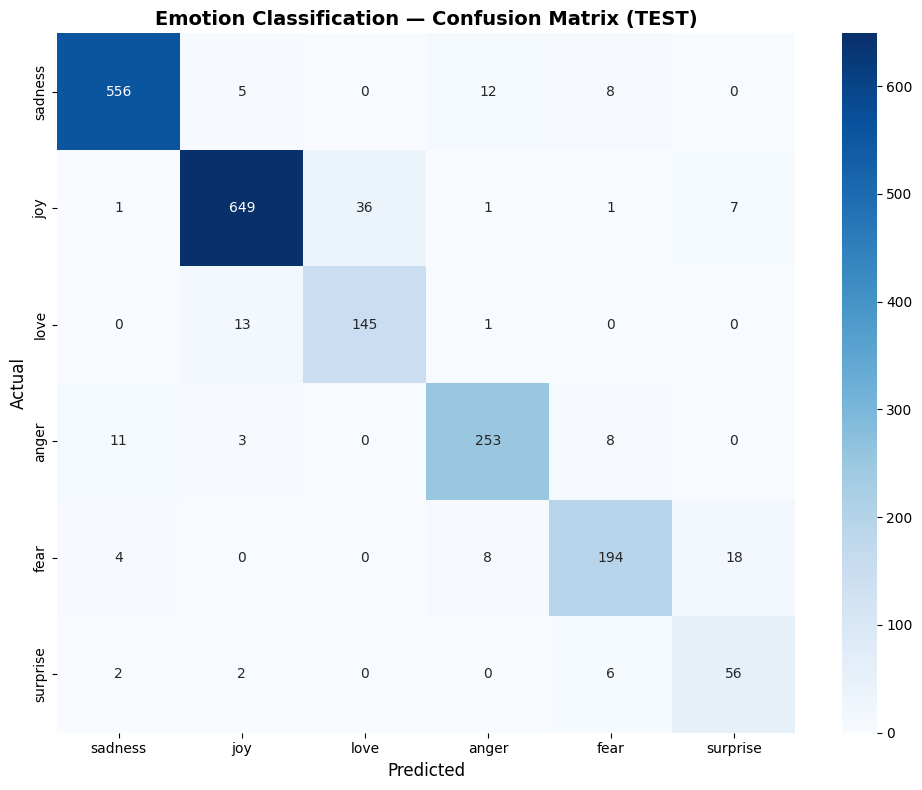

      Confusion matrix saved to: ./emotion_model_artifacts/confusion_matrix.png


In [13]:
# ---------------------------------
# 5.5 Confusion Matrix Visualization
# ---------------------------------
log("\n[5.5] Confusion Matrix (TEST):")

cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    ax=ax
)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Emotion Classification — Confusion Matrix (TEST)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"), dpi=150, bbox_inches='tight')
plt.show()

log(f"      Confusion matrix saved to: {OUTPUT_DIR}/confusion_matrix.png")

In [14]:
# ---------------------------------
# 5.6 Per-Class Performance Analysis
# ---------------------------------
log("\n[5.6] Per-Class Performance Analysis:")
log("-" * 60)

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)

log(f"\n{'Emotion':>12} | {'Precision':>10} | {'Recall':>10} | {'F1':>10} | {'Support':>10}")
log("-" * 60)
for i, emotion in EMOTION_LABELS.items():
    log(f"{emotion:>12} | {precision[i]:>10.3f} | {recall[i]:>10.3f} | {f1[i]:>10.3f} | {support[i]:>10}")

log("\n[OK] Model training and evaluation complete.")


[5.6] Per-Class Performance Analysis:
------------------------------------------------------------

     Emotion |  Precision |     Recall |         F1 |    Support
------------------------------------------------------------
     sadness |      0.969 |      0.957 |      0.963 |        581
         joy |      0.966 |      0.934 |      0.950 |        695
        love |      0.801 |      0.912 |      0.853 |        159
       anger |      0.920 |      0.920 |      0.920 |        275
        fear |      0.894 |      0.866 |      0.880 |        224
    surprise |      0.691 |      0.848 |      0.762 |         66

[OK] Model training and evaluation complete.


<br>

---

## Task 06 — Export Model Artifacts

Save all components needed for inference:

| Artifact | File | Purpose |
|----------|------|--------|
| Classifier | `classifier.joblib` | Trained logistic regression model |
| Scaler | `scaler.joblib` | Fitted StandardScaler (μ, σ) |
| Config | `config.json` | Model name, labels, metrics |

In [15]:
# ============================================================================
# STEP 6 — EXPORT MODEL ARTIFACTS
# ============================================================================
log("\n" + "="*70)
log("STEP 6 — EXPORT MODEL ARTIFACTS")
log("="*70)

import json

# ---------------------------------
# 6.1 Save Classifier
# ---------------------------------
classifier_path = os.path.join(OUTPUT_DIR, "classifier.joblib")
joblib.dump(classifier, classifier_path)
log(f"\n[6.1] Classifier saved: {classifier_path}")

# ---------------------------------
# 6.2 Save Scaler
# ---------------------------------
scaler_path = os.path.join(OUTPUT_DIR, "scaler.joblib")
joblib.dump(scaler, scaler_path)
log(f"[6.2] Scaler saved: {scaler_path}")

# ---------------------------------
# 6.3 Save Configuration
# ---------------------------------
config = {
    "model_name": MODEL_NAME,
    "embedding_dim": EMBEDDING_DIM,
    "max_seq_length": MAX_SEQ_LENGTH,
    "num_classes": NUM_CLASSES,
    "emotion_labels": EMOTION_LABELS,
    "label_to_emotion": {str(k): v for k, v in EMOTION_LABELS.items()},
    "emotion_to_label": {v: k for k, v in EMOTION_LABELS.items()},
    "training_metrics": {
        "accuracy_train": float(train_acc),
        "accuracy_val": float(val_acc),
        "accuracy_test": float(test_acc),
        "balanced_accuracy_train": float(train_ba),
        "balanced_accuracy_val": float(val_ba),
        "balanced_accuracy_test": float(test_ba),
        "f1_macro_test": float(test_f1)
    },
    "dataset": "dair-ai/emotion",
    "train_samples": len(df_train),
    "val_samples": len(df_val),
    "test_samples": len(df_test)
}

config_path = os.path.join(OUTPUT_DIR, "config.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=2)
log(f"[6.3] Config saved: {config_path}")


STEP 6 — EXPORT MODEL ARTIFACTS

[6.1] Classifier saved: ./emotion_model_artifacts\classifier.joblib
[6.2] Scaler saved: ./emotion_model_artifacts\scaler.joblib
[6.3] Config saved: ./emotion_model_artifacts\config.json


In [16]:
# ---------------------------------
# 6.4 Summary
# ---------------------------------
log("\n" + "="*70)
log("TRAINING COMPLETE — SUMMARY")
log("="*70)

log(f"\n📊 Model Performance:")
log(f"   - Test Accuracy:          {test_acc:.4f}")
log(f"   - Test Balanced Accuracy: {test_ba:.4f}")
log(f"   - Test Macro F1:          {test_f1:.4f}")

log(f"\n📁 Output Directory: {OUTPUT_DIR}")
log(f"\n📦 Saved Artifacts:")
for f in os.listdir(OUTPUT_DIR):
    fpath = os.path.join(OUTPUT_DIR, f)
    size = os.path.getsize(fpath) / 1024
    log(f"   - {f} ({size:.1f} KB)")

log(f"\n🏷️ Emotion Classes:")
for label, emotion in EMOTION_LABELS.items():
    log(f"   {label}: {emotion}")

log("\n" + "="*70)
log("✅ All artifacts saved. Ready for inference.")
log("="*70)


TRAINING COMPLETE — SUMMARY

📊 Model Performance:
   - Test Accuracy:          0.9265
   - Test Balanced Accuracy: 0.9062
   - Test Macro F1:          0.8878

📁 Output Directory: ./emotion_model_artifacts

📦 Saved Artifacts:
   - classifier.joblib (36.9 KB)
   - config.json (1.0 KB)
   - confusion_matrix.png (69.2 KB)
   - scaler.joblib (18.6 KB)

🏷️ Emotion Classes:
   0: sadness
   1: joy
   2: love
   3: anger
   4: fear
   5: surprise

✅ All artifacts saved. Ready for inference.


<br>

---

## Quick Test: Sample Predictions

Verify the model works on sample texts.

In [17]:
# ============================================================================
# QUICK TEST: Sample Predictions
# ============================================================================

test_sentences = [
    "I am so happy today, everything is going great!",
    "I feel so alone and nobody understands me.",
    "I love spending time with my family.",
    "This is so frustrating, I can't believe they did that!",
    "I'm really worried about what might happen tomorrow.",
    "Wow, I didn't expect that at all!"
]

log("\n" + "="*70)
log("QUICK TEST — SAMPLE PREDICTIONS")
log("="*70)

for text in test_sentences:
    # Normalize
    text_norm = normalize_text(text)
    
    # Embed
    emb = extract_embeddings([text_norm], show_progress=False)
    
    # Scale
    emb_scaled = scaler.transform(emb)
    
    # Predict
    pred = classifier.predict(emb_scaled)[0]
    proba = classifier.predict_proba(emb_scaled)[0]
    confidence = proba[pred]
    emotion = EMOTION_LABELS[pred]
    
    log(f"\n📝 \"{text[:50]}...\"")
    log(f"   → Predicted: {emotion.upper()} (confidence: {confidence:.1%})")


QUICK TEST — SAMPLE PREDICTIONS

📝 "I am so happy today, everything is going great!..."
   → Predicted: JOY (confidence: 100.0%)

📝 "I feel so alone and nobody understands me...."
   → Predicted: SADNESS (confidence: 100.0%)

📝 "I love spending time with my family...."
   → Predicted: JOY (confidence: 100.0%)

📝 "This is so frustrating, I can't believe they did t..."
   → Predicted: ANGER (confidence: 100.0%)

📝 "I'm really worried about what might happen tomorro..."
   → Predicted: FEAR (confidence: 100.0%)

📝 "Wow, I didn't expect that at all!..."
   → Predicted: SADNESS (confidence: 50.6%)
